In [118]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logging
import surprise
logging.basicConfig(format='%(levelname)s: %(message)s', level=logging.INFO)

In [2]:
df = pd.read_csv('../data/votes2', sep=' ', names=['VN_id', 'user_id', 'vote', 'date'])

In [3]:
df.head()

,VN_id,user_id,vote,date
0,3965,13742,70,2012-01-10
1,3031,7143,60,2011-12-04
2,292,521,71,2012-01-02
3,1310,521,61,2011-12-09
4,2678,521,63,2011-12-02


In [4]:
df.groupby('user_id').count().describe() #35k users have voted

,VN_id,vote,date
count,34838.000000,34838.000000,34838.000000
mean,18.004593,18.004593,18.004593
std,47.930986,47.930986,47.930986
min,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000
50%,6.000000,6.000000,6.000000
75%,18.000000,18.000000,18.000000
max,3413.000000,3413.000000,3413.000000


In [5]:
len(df)

627244

In [6]:
df.groupby('user_id').count()['VN_id'];

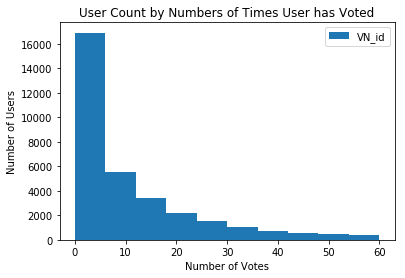

In [7]:
df.groupby('user_id').count()[['VN_id']].plot(kind = 'hist', range=[0,60])
plt.title('User Count by Numbers of Times User has Voted')
plt.ylabel('Number of Users')
plt.xlabel('Number of Votes')
plt.show()

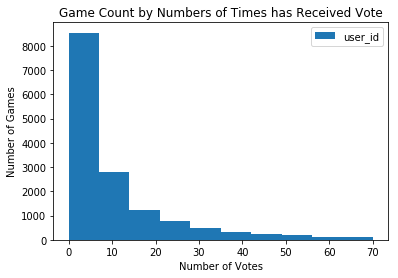

In [8]:
df.groupby('VN_id').count()[['user_id']].plot(kind= 'hist', range = [0,70])
plt.title('Game Count by Numbers of Times has Received Vote')
plt.ylabel('Number of Games')
plt.xlabel('Number of Votes')
plt.show()

In [9]:
df.groupby('VN_id').count()[['user_id']].sort_values('user_id', ascending=False).describe() #on 16k games

,user_id
count,15954.000000
mean,39.315783
std,241.880708
min,1.000000
25%,2.000000
50%,6.000000
75%,17.000000
max,8789.000000


In [68]:
sum(df.groupby('user_id').count()[['VN_id']]['VN_id']>15) #8k users over 20 games rated hmm

9995

In [11]:
sum(df.groupby('VN_id').count()[['user_id']]['user_id']>20) #3k games with over 20 ratings, not bad!

3390

In [12]:
sum(df.groupby('VN_id').count()[['user_id']]['user_id']>100) #only 800 with more than 100 ratings

826

In [12]:
from recommend.bpmf import BPMF
from recommend.utils.evaluation import RMSE

In [13]:
n_items = len(np.unique(df['VN_id']))
n_users = len(np.unique(df['user_id']))
#dictionary to remap users and items to 1:len(uniques)+1
item_dict = {x: y for (x, y) in zip(np.unique(df['VN_id']), range(n_items))}
user_dict = {x: y for (x, y) in zip(np.unique(df['user_id']), range(n_users))}
df['VN_id'] = df['VN_id'].map(item_dict)
df['user_id'] = df['user_id'].map(user_dict)
mtx2 = df.drop('date', axis=1).as_matrix()
mtx = mtx2[:,[1,0,2]]

In [13]:
print(n_items, 'unique games')
print(n_users, 'unique users')

NameError: name 'n_items' is not defined

In [14]:
from sklearn.model_selection import train_test_split

In [17]:
mtx = df.drop('date', axis=1).as_matrix()
X = mtx[:,:2]
y = mtx[:,2]
print(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25)
print(len(X_train), len(y_train), len(X_test), len(y_test)) #nice!

[[  3965  13742]
 [  3031   7143]
 [   292    521]
 ...
 [ 18825 144155]
 [ 17694 144155]
 [ 16221 144155]] [70 60 71 ... 70 70 50]
470433 470433 156811 156811


In [18]:
train, test = train_test_split(mtx, test_size=.25)
print(len(train), len(test))

470433 156811


In [19]:
max(mtx[:,1])

150121

In [26]:
latent_features = [10,20,30,40,50]
n_iterations = 20

In [27]:
print("training BPMF model...")
for latent_feature in latent_features:
    bpmf = BPMF(n_user=n_users, n_item=n_items, n_feature=latent_feature, max_rating=100, min_rating=10)
    bpmf.fit(train, n_iters=n_iterations)
    bpmf_train_preds = bpmf.predict(train[:, :2])
    bpmf_train_rmse = RMSE(bpmf_train_preds, train[:, 2])
    bpmf_val_preds = bpmf.predict(test[:, :2])
    bpmf_val_rmse = RMSE(bpmf_val_preds, test[:, 2])
    print("BPMF training RMSE %.3f, validation RMSE %.3f" % (bpmf_train_rmse, bpmf_val_rmse))

training BPMF model...


INFO: iteration: 1, train RMSE: 14.635525
INFO: iteration: 2, train RMSE: 11.352939
INFO: iteration: 3, train RMSE: 9.794030
INFO: iteration: 4, train RMSE: 8.961848
INFO: iteration: 5, train RMSE: 8.460539
INFO: iteration: 6, train RMSE: 8.130744
INFO: iteration: 7, train RMSE: 7.900489
INFO: iteration: 8, train RMSE: 7.730853
INFO: iteration: 9, train RMSE: 7.602648
INFO: iteration: 10, train RMSE: 7.501892
INFO: iteration: 11, train RMSE: 7.421094
INFO: iteration: 12, train RMSE: 7.354578
INFO: iteration: 13, train RMSE: 7.299495
INFO: iteration: 14, train RMSE: 7.253059
INFO: iteration: 15, train RMSE: 7.213495
INFO: iteration: 16, train RMSE: 7.179254
INFO: iteration: 17, train RMSE: 7.149022
INFO: iteration: 18, train RMSE: 7.122991
INFO: iteration: 19, train RMSE: 7.099607
INFO: iteration: 20, train RMSE: 7.079049


BPMF training RMSE 7.079, validation RMSE 17.692


INFO: iteration: 1, train RMSE: 13.888528
INFO: iteration: 2, train RMSE: 9.858076
INFO: iteration: 3, train RMSE: 8.010176
INFO: iteration: 4, train RMSE: 7.021037
INFO: iteration: 5, train RMSE: 6.421558
INFO: iteration: 6, train RMSE: 6.027336
INFO: iteration: 7, train RMSE: 5.753493
INFO: iteration: 8, train RMSE: 5.552645
INFO: iteration: 9, train RMSE: 5.400831
INFO: iteration: 10, train RMSE: 5.282365
INFO: iteration: 11, train RMSE: 5.187172
INFO: iteration: 12, train RMSE: 5.109693
INFO: iteration: 13, train RMSE: 5.044705
INFO: iteration: 14, train RMSE: 4.990680
INFO: iteration: 15, train RMSE: 4.943976
INFO: iteration: 16, train RMSE: 4.903961
INFO: iteration: 17, train RMSE: 4.869281
INFO: iteration: 18, train RMSE: 4.838784
INFO: iteration: 19, train RMSE: 4.811736
INFO: iteration: 20, train RMSE: 4.787706


BPMF training RMSE 4.788, validation RMSE 18.346


INFO: iteration: 1, train RMSE: 13.251520
INFO: iteration: 2, train RMSE: 8.912878
INFO: iteration: 3, train RMSE: 6.959074
INFO: iteration: 4, train RMSE: 5.900779
INFO: iteration: 5, train RMSE: 5.251646
INFO: iteration: 6, train RMSE: 4.820793
INFO: iteration: 7, train RMSE: 4.519226
INFO: iteration: 8, train RMSE: 4.299135
INFO: iteration: 9, train RMSE: 4.133010
INFO: iteration: 10, train RMSE: 4.003255
INFO: iteration: 11, train RMSE: 3.899785
INFO: iteration: 12, train RMSE: 3.815824
INFO: iteration: 13, train RMSE: 3.746226
INFO: iteration: 14, train RMSE: 3.688302
INFO: iteration: 15, train RMSE: 3.639461
INFO: iteration: 16, train RMSE: 3.597908
INFO: iteration: 17, train RMSE: 3.561997
INFO: iteration: 18, train RMSE: 3.529753
INFO: iteration: 19, train RMSE: 3.501775
INFO: iteration: 20, train RMSE: 3.477006


BPMF training RMSE 3.477, validation RMSE 17.667


KeyboardInterrupt: 

In [39]:
user_id = 0

pred_items = np.array([[user_id, i] for i in range(10000)])
# pmf
bpmf_pred = bpmf.predict(pred_items)

print("PMF/BPMF prediction for user %d" % user_id)
for i in range(10000):
    print("item %d: bpmf: %.3f" % (i, bpmf_pred[i]))

PMF/BPMF prediction for user 0
item 0: bpmf: 72.585
item 1: bpmf: 72.585
item 2: bpmf: 72.585
item 3: bpmf: 72.585
item 4: bpmf: 72.585
item 5: bpmf: 72.585
item 6: bpmf: 72.585
item 7: bpmf: 72.585
item 8: bpmf: 72.585
item 9: bpmf: 72.585
item 10: bpmf: 72.585
item 11: bpmf: 72.585
item 12: bpmf: 72.585
item 13: bpmf: 72.585
item 14: bpmf: 72.585
item 15: bpmf: 72.585
item 16: bpmf: 72.585
item 17: bpmf: 72.585
item 18: bpmf: 72.585
item 19: bpmf: 72.585
item 20: bpmf: 72.585
item 21: bpmf: 72.585
item 22: bpmf: 72.585
item 23: bpmf: 72.585
item 24: bpmf: 72.585
item 25: bpmf: 72.585
item 26: bpmf: 72.585
item 27: bpmf: 72.585
item 28: bpmf: 72.585
item 29: bpmf: 72.585
item 30: bpmf: 72.585
item 31: bpmf: 72.585
item 32: bpmf: 72.585
item 33: bpmf: 72.585
item 34: bpmf: 72.585
item 35: bpmf: 72.585
item 36: bpmf: 72.585
item 37: bpmf: 72.585
item 38: bpmf: 72.585
item 39: bpmf: 72.585
item 40: bpmf: 72.585
item 41: bpmf: 72.585
item 42: bpmf: 72.585
item 43: bpmf: 72.585
item 44: bp

item 1446: bpmf: 72.585
item 1447: bpmf: 72.585
item 1448: bpmf: 72.585
item 1449: bpmf: 72.585
item 1450: bpmf: 72.585
item 1451: bpmf: 72.585
item 1452: bpmf: 72.585
item 1453: bpmf: 72.585
item 1454: bpmf: 72.585
item 1455: bpmf: 72.585
item 1456: bpmf: 72.585
item 1457: bpmf: 72.585
item 1458: bpmf: 72.585
item 1459: bpmf: 72.585
item 1460: bpmf: 72.585
item 1461: bpmf: 72.585
item 1462: bpmf: 72.585
item 1463: bpmf: 72.585
item 1464: bpmf: 72.585
item 1465: bpmf: 72.585
item 1466: bpmf: 72.585
item 1467: bpmf: 72.585
item 1468: bpmf: 72.585
item 1469: bpmf: 72.585
item 1470: bpmf: 72.585
item 1471: bpmf: 72.585
item 1472: bpmf: 72.585
item 1473: bpmf: 72.585
item 1474: bpmf: 72.585
item 1475: bpmf: 72.585
item 1476: bpmf: 72.585
item 1477: bpmf: 72.585
item 1478: bpmf: 72.585
item 1479: bpmf: 72.585
item 1480: bpmf: 72.585
item 1481: bpmf: 72.585
item 1482: bpmf: 72.585
item 1483: bpmf: 72.585
item 1484: bpmf: 72.585
item 1485: bpmf: 72.585
item 1486: bpmf: 72.585
item 1487: bpmf:

item 2446: bpmf: 72.585
item 2447: bpmf: 72.585
item 2448: bpmf: 72.585
item 2449: bpmf: 72.585
item 2450: bpmf: 72.585
item 2451: bpmf: 72.585
item 2452: bpmf: 72.585
item 2453: bpmf: 72.585
item 2454: bpmf: 72.585
item 2455: bpmf: 72.585
item 2456: bpmf: 72.585
item 2457: bpmf: 72.585
item 2458: bpmf: 72.585
item 2459: bpmf: 72.585
item 2460: bpmf: 72.585
item 2461: bpmf: 72.585
item 2462: bpmf: 72.585
item 2463: bpmf: 72.585
item 2464: bpmf: 72.585
item 2465: bpmf: 72.585
item 2466: bpmf: 72.585
item 2467: bpmf: 72.585
item 2468: bpmf: 72.585
item 2469: bpmf: 72.585
item 2470: bpmf: 72.585
item 2471: bpmf: 72.585
item 2472: bpmf: 72.585
item 2473: bpmf: 72.585
item 2474: bpmf: 72.585
item 2475: bpmf: 72.585
item 2476: bpmf: 72.585
item 2477: bpmf: 72.585
item 2478: bpmf: 72.585
item 2479: bpmf: 72.585
item 2480: bpmf: 72.585
item 2481: bpmf: 72.585
item 2482: bpmf: 72.585
item 2483: bpmf: 72.585
item 2484: bpmf: 72.585
item 2485: bpmf: 72.585
item 2486: bpmf: 72.585
item 2487: bpmf:

item 3445: bpmf: 72.585
item 3446: bpmf: 72.585
item 3447: bpmf: 72.585
item 3448: bpmf: 72.585
item 3449: bpmf: 72.585
item 3450: bpmf: 72.585
item 3451: bpmf: 72.585
item 3452: bpmf: 72.585
item 3453: bpmf: 72.585
item 3454: bpmf: 72.585
item 3455: bpmf: 72.585
item 3456: bpmf: 72.585
item 3457: bpmf: 72.585
item 3458: bpmf: 72.585
item 3459: bpmf: 72.585
item 3460: bpmf: 72.585
item 3461: bpmf: 72.585
item 3462: bpmf: 72.585
item 3463: bpmf: 72.585
item 3464: bpmf: 72.585
item 3465: bpmf: 72.585
item 3466: bpmf: 72.585
item 3467: bpmf: 72.585
item 3468: bpmf: 72.585
item 3469: bpmf: 72.585
item 3470: bpmf: 72.585
item 3471: bpmf: 72.585
item 3472: bpmf: 72.585
item 3473: bpmf: 72.585
item 3474: bpmf: 72.585
item 3475: bpmf: 72.585
item 3476: bpmf: 72.585
item 3477: bpmf: 72.585
item 3478: bpmf: 72.585
item 3479: bpmf: 72.585
item 3480: bpmf: 72.585
item 3481: bpmf: 72.585
item 3482: bpmf: 72.585
item 3483: bpmf: 72.585
item 3484: bpmf: 72.585
item 3485: bpmf: 72.585
item 3486: bpmf:

item 4445: bpmf: 72.585
item 4446: bpmf: 72.585
item 4447: bpmf: 72.585
item 4448: bpmf: 72.585
item 4449: bpmf: 72.585
item 4450: bpmf: 72.585
item 4451: bpmf: 72.585
item 4452: bpmf: 72.585
item 4453: bpmf: 72.585
item 4454: bpmf: 72.585
item 4455: bpmf: 72.585
item 4456: bpmf: 72.585
item 4457: bpmf: 72.585
item 4458: bpmf: 72.585
item 4459: bpmf: 72.585
item 4460: bpmf: 72.585
item 4461: bpmf: 72.585
item 4462: bpmf: 72.585
item 4463: bpmf: 72.585
item 4464: bpmf: 72.585
item 4465: bpmf: 72.585
item 4466: bpmf: 72.585
item 4467: bpmf: 72.585
item 4468: bpmf: 72.585
item 4469: bpmf: 72.585
item 4470: bpmf: 72.585
item 4471: bpmf: 72.585
item 4472: bpmf: 72.585
item 4473: bpmf: 72.585
item 4474: bpmf: 72.585
item 4475: bpmf: 72.585
item 4476: bpmf: 72.585
item 4477: bpmf: 72.585
item 4478: bpmf: 72.585
item 4479: bpmf: 72.585
item 4480: bpmf: 72.585
item 4481: bpmf: 72.585
item 4482: bpmf: 72.585
item 4483: bpmf: 72.585
item 4484: bpmf: 72.585
item 4485: bpmf: 72.585
item 4486: bpmf:

item 5790: bpmf: 72.585
item 5791: bpmf: 72.585
item 5792: bpmf: 72.585
item 5793: bpmf: 72.585
item 5794: bpmf: 72.585
item 5795: bpmf: 72.585
item 5796: bpmf: 72.585
item 5797: bpmf: 72.585
item 5798: bpmf: 72.585
item 5799: bpmf: 72.585
item 5800: bpmf: 72.585
item 5801: bpmf: 72.585
item 5802: bpmf: 72.585
item 5803: bpmf: 72.585
item 5804: bpmf: 72.585
item 5805: bpmf: 72.585
item 5806: bpmf: 72.585
item 5807: bpmf: 72.585
item 5808: bpmf: 72.585
item 5809: bpmf: 72.585
item 5810: bpmf: 72.585
item 5811: bpmf: 72.585
item 5812: bpmf: 72.585
item 5813: bpmf: 72.585
item 5814: bpmf: 72.585
item 5815: bpmf: 72.585
item 5816: bpmf: 72.585
item 5817: bpmf: 72.585
item 5818: bpmf: 72.585
item 5819: bpmf: 72.585
item 5820: bpmf: 72.585
item 5821: bpmf: 72.585
item 5822: bpmf: 72.585
item 5823: bpmf: 72.585
item 5824: bpmf: 72.585
item 5825: bpmf: 72.585
item 5826: bpmf: 72.585
item 5827: bpmf: 72.585
item 5828: bpmf: 72.585
item 5829: bpmf: 72.585
item 5830: bpmf: 72.585
item 5831: bpmf:

item 6444: bpmf: 72.585
item 6445: bpmf: 72.585
item 6446: bpmf: 72.585
item 6447: bpmf: 72.585
item 6448: bpmf: 72.585
item 6449: bpmf: 72.585
item 6450: bpmf: 72.585
item 6451: bpmf: 72.585
item 6452: bpmf: 72.585
item 6453: bpmf: 72.585
item 6454: bpmf: 72.585
item 6455: bpmf: 72.585
item 6456: bpmf: 72.585
item 6457: bpmf: 72.585
item 6458: bpmf: 72.585
item 6459: bpmf: 72.585
item 6460: bpmf: 72.585
item 6461: bpmf: 72.585
item 6462: bpmf: 72.585
item 6463: bpmf: 72.585
item 6464: bpmf: 72.585
item 6465: bpmf: 72.585
item 6466: bpmf: 72.585
item 6467: bpmf: 72.585
item 6468: bpmf: 72.585
item 6469: bpmf: 72.585
item 6470: bpmf: 72.585
item 6471: bpmf: 72.585
item 6472: bpmf: 72.585
item 6473: bpmf: 72.585
item 6474: bpmf: 72.585
item 6475: bpmf: 72.585
item 6476: bpmf: 72.585
item 6477: bpmf: 72.585
item 6478: bpmf: 72.585
item 6479: bpmf: 72.585
item 6480: bpmf: 72.585
item 6481: bpmf: 72.585
item 6482: bpmf: 72.585
item 6483: bpmf: 72.585
item 6484: bpmf: 72.585
item 6485: bpmf:

item 7443: bpmf: 72.585
item 7444: bpmf: 72.585
item 7445: bpmf: 72.585
item 7446: bpmf: 72.585
item 7447: bpmf: 72.585
item 7448: bpmf: 72.585
item 7449: bpmf: 72.585
item 7450: bpmf: 72.585
item 7451: bpmf: 72.585
item 7452: bpmf: 72.585
item 7453: bpmf: 72.585
item 7454: bpmf: 72.585
item 7455: bpmf: 72.585
item 7456: bpmf: 72.585
item 7457: bpmf: 72.585
item 7458: bpmf: 72.585
item 7459: bpmf: 72.585
item 7460: bpmf: 72.585
item 7461: bpmf: 72.585
item 7462: bpmf: 72.585
item 7463: bpmf: 72.585
item 7464: bpmf: 72.585
item 7465: bpmf: 72.585
item 7466: bpmf: 72.585
item 7467: bpmf: 72.585
item 7468: bpmf: 72.585
item 7469: bpmf: 72.585
item 7470: bpmf: 72.585
item 7471: bpmf: 72.585
item 7472: bpmf: 72.585
item 7473: bpmf: 72.585
item 7474: bpmf: 72.585
item 7475: bpmf: 72.585
item 7476: bpmf: 72.585
item 7477: bpmf: 72.585
item 7478: bpmf: 72.585
item 7479: bpmf: 72.585
item 7480: bpmf: 72.585
item 7481: bpmf: 72.585
item 7482: bpmf: 72.585
item 7483: bpmf: 72.585
item 7484: bpmf:

item 8443: bpmf: 72.585
item 8444: bpmf: 72.585
item 8445: bpmf: 72.585
item 8446: bpmf: 72.585
item 8447: bpmf: 72.585
item 8448: bpmf: 72.585
item 8449: bpmf: 72.585
item 8450: bpmf: 72.585
item 8451: bpmf: 72.585
item 8452: bpmf: 72.585
item 8453: bpmf: 72.585
item 8454: bpmf: 72.585
item 8455: bpmf: 72.585
item 8456: bpmf: 72.585
item 8457: bpmf: 72.585
item 8458: bpmf: 72.585
item 8459: bpmf: 72.585
item 8460: bpmf: 72.585
item 8461: bpmf: 72.585
item 8462: bpmf: 72.585
item 8463: bpmf: 72.585
item 8464: bpmf: 72.585
item 8465: bpmf: 72.585
item 8466: bpmf: 72.585
item 8467: bpmf: 72.585
item 8468: bpmf: 72.585
item 8469: bpmf: 72.585
item 8470: bpmf: 72.585
item 8471: bpmf: 72.585
item 8472: bpmf: 72.585
item 8473: bpmf: 72.585
item 8474: bpmf: 72.585
item 8475: bpmf: 72.585
item 8476: bpmf: 72.585
item 8477: bpmf: 72.585
item 8478: bpmf: 72.585
item 8479: bpmf: 72.585
item 8480: bpmf: 72.585
item 8481: bpmf: 72.585
item 8482: bpmf: 72.585
item 8483: bpmf: 72.585
item 8484: bpmf:

item 9442: bpmf: 72.585
item 9443: bpmf: 72.585
item 9444: bpmf: 72.585
item 9445: bpmf: 72.585
item 9446: bpmf: 72.585
item 9447: bpmf: 72.585
item 9448: bpmf: 72.585
item 9449: bpmf: 72.585
item 9450: bpmf: 72.585
item 9451: bpmf: 72.585
item 9452: bpmf: 72.585
item 9453: bpmf: 72.585
item 9454: bpmf: 72.585
item 9455: bpmf: 72.585
item 9456: bpmf: 72.585
item 9457: bpmf: 72.585
item 9458: bpmf: 72.585
item 9459: bpmf: 72.585
item 9460: bpmf: 72.585
item 9461: bpmf: 72.585
item 9462: bpmf: 72.585
item 9463: bpmf: 72.585
item 9464: bpmf: 72.585
item 9465: bpmf: 72.585
item 9466: bpmf: 72.585
item 9467: bpmf: 72.585
item 9468: bpmf: 72.585
item 9469: bpmf: 72.585
item 9470: bpmf: 72.585
item 9471: bpmf: 72.585
item 9472: bpmf: 72.585
item 9473: bpmf: 72.585
item 9474: bpmf: 72.585
item 9475: bpmf: 72.585
item 9476: bpmf: 72.585
item 9477: bpmf: 72.585
item 9478: bpmf: 72.585
item 9479: bpmf: 72.585
item 9480: bpmf: 72.585
item 9481: bpmf: 72.585
item 9482: bpmf: 72.585
item 9483: bpmf:

In [40]:
train[:,2].mean()

72.58458483992408

it seems the baseline bayesian model ends up just literally predicting the mean (or close to it)
maybe I will be able to improve this model through clustering through use of the tags system, or use factorization machines (libfm)

alternatively I could fill the baseline with the average of scores for each unfilled game

this is probably not a good idea, since the majority of works are not translated, and therefore may not be
appropriate for recommending, along with the fact that some games are popular among certain crowds
that may skew votes

maybe it'll be better to take samples from games that are only voted on with high frequency.
something I want to avoid is just mindlessly offering the most popular game

regardless, it seems like I am also overfitting my data, based on the difference between the training and test set data
should try kfold validation

In [3]:
svdmodel = surprise.prediction_algorithms.matrix_factorization.SVDpp(n_epochs=1)
reader = surprise.Reader(rating_scale=(10,100))
data = surprise.dataset.Dataset.load_from_df(df[['user_id', 'VN_id', 'vote']], reader)

In [3]:
finding = surprise.model_selection.cross_validate(svdmodel, data, verbose = True)

NameError: name 'svdmodel' is not defined

627244/60555805452 = 0.00001

i am dealing with 0.99999 sparsity here. in comparison, the netflix data is only .95 sparse

In [4]:
(df.groupby('user_id').count()[['VN_id']]['VN_id']>20).head()

user_id
2     True
4    False
5     True
6    False
7    False
Name: VN_id, dtype: bool

In [4]:
user_ser = (df.groupby('user_id').count()[['VN_id']]['VN_id']>15)

In [5]:
ser = (df.groupby('VN_id').count()[['user_id']]['user_id']>20)

In [6]:
df.groupby('VN_id').count().head()

,user_id,vote,date
VN_id,,,
1,517,517,517
2,1251,1251,1251
3,2532,2532,2532
4,5066,5066,5066
5,4500,4500,4500


In [7]:
user_ser.keys()[user_ser]

Int64Index([     2,      5,      8,      9,     12,     13,     15,     28,
                29,     31,
            ...
            149748, 149758, 149762, 149835, 149853, 149868, 149929, 149941,
            149966, 150074],
           dtype='int64', name='user_id', length=9995)

In [8]:
high_user_votes_df = df[df['VN_id'].isin(ser.keys()[ser])][df[df['VN_id'].isin(ser.keys()[ser])]['user_id'].isin(user_ser.keys()[user_ser])]

In [10]:
ser.keys()[ser]

Int64Index([    1,     2,     3,     4,     5,     6,     7,     8,     9,
               10,
            ...
            22542, 22553, 22570, 22583, 22648, 22790, 22791, 22792, 22798,
            22948],
           dtype='int64', name='VN_id', length=3390)

In [11]:
len(high_user_votes_df['VN_id'].unique())

3390

In [12]:
len(high_user_votes_df['user_id'].unique())

9993

In [79]:
pivoted = df[df['VN_id'].isin(ser.keys()[ser])].drop('date', axis=1).pivot(index = 'VN_id', columns = 'user_id')

In [11]:
pivoted.head()

NameError: name 'pivoted' is not defined

In [12]:
557860/(3390*33434)

0.004921949870682574

In [9]:
high_user_votes_df.head()

,VN_id,user_id,vote,date
1,3031,7143,60,2011-12-04
6,4334,521,58,2011-11-17
8,2342,521,74,2011-10-28
10,3939,521,67,2011-09-30
11,2537,521,75,2011-09-26


In [11]:
450827/(9995*3390)

0.013305384255549604

In [12]:
svdmodel = surprise.prediction_algorithms.matrix_factorization.SVD(n_epochs=3)
reader = surprise.Reader(rating_scale=(10,100))
data = surprise.dataset.Dataset.load_from_df(high_user_votes_df[['user_id', 'VN_id', 'vote']], reader)
cv = surprise.model_selection.KFold(n_splits=2)

In [14]:
finding = surprise.model_selection.cross_validate(svdmodel, data, cv=cv, verbose = True)

KeyboardInterrupt: 

In [137]:
finding

{'fit_time': (4.283566474914551, 4.681442499160767),
 'test_mae': array([9.4683129, 9.4514223]),
 'test_rmse': array([12.74843333, 12.72198208]),
 'test_time': (8.446557998657227, 7.725341558456421)}

In [140]:
data

In [13]:
trainset = data.build_full_trainset()

In [16]:
svdmodel.fit(trainset)

In [18]:
trainset.ur

defaultdict(list,
            {0: [(0, 60.0),
              (24, 90.0),
              (25, 90.0),
              (114, 65.0),
              (1203, 40.0),
              (499, 75.0),
              (169, 70.0),
              (133, 80.0),
              (39, 50.0),
              (1099, 60.0),
              (37, 70.0),
              (1659, 45.0),
              (424, 70.0),
              (345, 70.0),
              (32, 80.0),
              (129, 70.0),
              (29, 85.0),
              (147, 80.0),
              (67, 80.0),
              (23, 90.0),
              (141, 80.0),
              (75, 80.0),
              (87, 70.0),
              (96, 65.0),
              (125, 90.0),
              (170, 80.0),
              (151, 65.0),
              (463, 65.0),
              (136, 65.0),
              (102, 80.0),
              (70, 60.0),
              (21, 85.0),
              (52, 60.0),
              (160, 70.0),
              (154, 70.0),
              (155, 70.0),
              (397, 

In [43]:
fs = pd.DataFrame([(3,2,1),(5,4,6)],columns=['user_id', 'VN_id', 'vote'])

In [44]:
pd.concat([df,fs])

,VN_id,date,user_id,vote
0,3965,2012-01-10,13742,70
1,3031,2011-12-04,7143,60
2,292,2012-01-02,521,71
3,1310,2011-12-09,521,61
4,2678,2011-12-02,521,63
5,2633,2011-11-30,521,51
6,4334,2011-11-17,521,58
7,2344,2011-11-06,521,84
8,2342,2011-10-28,521,74
9,2293,2011-10-08,521,69


In [22]:
svdmodel

In [13]:
testset = trainset.build_anti_testset()

In [20]:
testset

[(7143, 4334, 72.46750749178732),
 (7143, 2342, 72.46750749178732),
 (7143, 3939, 72.46750749178732),
 (7143, 2537, 72.46750749178732),
 (7143, 181, 72.46750749178732),
 (7143, 21, 72.46750749178732),
 (7143, 648, 72.46750749178732),
 (7143, 3246, 72.46750749178732),
 (7143, 5435, 72.46750749178732),
 (7143, 2632, 72.46750749178732),
 (7143, 428, 72.46750749178732),
 (7143, 400, 72.46750749178732),
 (7143, 431, 72.46750749178732),
 (7143, 433, 72.46750749178732),
 (7143, 3684, 72.46750749178732),
 (7143, 105, 72.46750749178732),
 (7143, 430, 72.46750749178732),
 (7143, 870, 72.46750749178732),
 (7143, 4202, 72.46750749178732),
 (7143, 1438, 72.46750749178732),
 (7143, 4852, 72.46750749178732),
 (7143, 1451, 72.46750749178732),
 (7143, 899, 72.46750749178732),
 (7143, 556, 72.46750749178732),
 (7143, 147, 72.46750749178732),
 (7143, 165, 72.46750749178732),
 (7143, 47, 72.46750749178732),
 (7143, 398, 72.46750749178732),
 (7143, 286, 72.46750749178732),
 (7143, 737, 72.46750749178732),


In [19]:
list(trainset.all_ratings())

[(0, 0, 60.0),
 (0, 24, 90.0),
 (0, 25, 90.0),
 (0, 114, 65.0),
 (0, 1203, 40.0),
 (0, 499, 75.0),
 (0, 169, 70.0),
 (0, 133, 80.0),
 (0, 39, 50.0),
 (0, 1099, 60.0),
 (0, 37, 70.0),
 (0, 1659, 45.0),
 (0, 424, 70.0),
 (0, 345, 70.0),
 (0, 32, 80.0),
 (0, 129, 70.0),
 (0, 29, 85.0),
 (0, 147, 80.0),
 (0, 67, 80.0),
 (0, 23, 90.0),
 (0, 141, 80.0),
 (0, 75, 80.0),
 (0, 87, 70.0),
 (0, 96, 65.0),
 (0, 125, 90.0),
 (0, 170, 80.0),
 (0, 151, 65.0),
 (0, 463, 65.0),
 (0, 136, 65.0),
 (0, 102, 80.0),
 (0, 70, 60.0),
 (0, 21, 85.0),
 (0, 52, 60.0),
 (0, 160, 70.0),
 (0, 154, 70.0),
 (0, 155, 70.0),
 (0, 397, 60.0),
 (0, 1195, 70.0),
 (0, 34, 70.0),
 (0, 439, 60.0),
 (0, 387, 60.0),
 (0, 51, 70.0),
 (0, 448, 20.0),
 (0, 435, 70.0),
 (0, 311, 70.0),
 (0, 282, 45.0),
 (0, 298, 50.0),
 (0, 411, 70.0),
 (0, 410, 70.0),
 (0, 66, 70.0),
 (0, 372, 70.0),
 (0, 1190, 60.0),
 (0, 68, 80.0),
 (0, 69, 80.0),
 (0, 84, 80.0),
 (0, 513, 70.0),
 (0, 149, 60.0),
 (0, 443, 60.0),
 (0, 131, 70.0),
 (0, 85, 70.0)

In [ ]:
pred = svdmodel.test(testset)

In [51]:
svdmodel.test([(633, 4, 72.46)], verbose=True)

user: 633        item: 4          r_ui = 72.46   est = 83.43   {'was_impossible': False}


[Prediction(uid=633, iid=4, r_ui=72.46, est=83.43312027562357, details={'was_impossible': False})]

In [14]:
ccmodel = surprise.prediction_algorithms.co_clustering.CoClustering(n_cltr_i=5,verbose=True)
reader = surprise.Reader(rating_scale=(10,100))
data = surprise.dataset.Dataset.load_from_df(high_user_votes_df[['user_id', 'VN_id', 'vote']], reader)
cv = surprise.model_selection.KFold(n_splits=2)

In [12]:
trainset = data.build_full_trainset()

In [13]:
ccmodel.fit(trainset)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19


In [26]:
surprise.model_selection.cross_validate(ccmodel, data, cv=cv, verbose = True)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Evaluating RMSE, MAE of algorithm CoClustering on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    13.6354 13.6935 13.6644 0.0291  
MAE (testset)     10.3222 10.3501 10.3361 0.0140  
Fit 

{'fit_time': (16.633991479873657, 17.281115293502808),
 'test_mae': array([10.32216128, 10.35011713]),
 'test_rmse': array([13.63535071, 13.69352054]),
 'test_time': (5.483792304992676, 5.408373832702637)}

In [58]:
ccmodel = surprise.prediction_algorithms.co_clustering.CoClustering(n_cltr_u=1,n_cltr_i=1,verbose=True)
reader = surprise.Reader(rating_scale=(10,100))
data = surprise.dataset.Dataset.load_from_df(high_user_votes_df[['user_id', 'VN_id', 'vote']], reader)
cv = surprise.model_selection.KFold(n_splits=3)
surprise.model_selection.cross_validate(ccmodel, data, cv=cv, verbose = True)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing

{'fit_time': (16.570022583007812, 16.61553144454956, 17.115221977233887),
 'test_mae': array([10.10569832, 10.14721162, 10.15758681]),
 'test_rmse': array([13.39289669, 13.43246072, 13.44149111]),
 'test_time': (4.393131494522095, 4.614657640457153, 4.2599427700042725)}

In [56]:
ccmodel.estimate(3,4)

58.143044495135925

In [59]:
ccmodel = surprise.prediction_algorithms.co_clustering.CoClustering(n_cltr_u=2,n_cltr_i=1,verbose=True)
reader = surprise.Reader(rating_scale=(10,100))
data = surprise.dataset.Dataset.load_from_df(high_user_votes_df[['user_id', 'VN_id', 'vote']], reader)
cv = surprise.model_selection.KFold(n_splits=3)
surprise.model_selection.cross_validate(ccmodel, data, cv=cv, verbose = True)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing

{'fit_time': (16.813695907592773, 16.945878744125366, 17.269200563430786),
 'test_mae': array([10.17683302, 10.11975076, 10.13329259]),
 'test_rmse': array([13.50583729, 13.37451574, 13.41068369]),
 'test_time': (4.125475168228149, 4.015531063079834, 4.052107334136963)}

In [60]:
ccmodel = surprise.prediction_algorithms.co_clustering.CoClustering(n_cltr_u=2,n_cltr_i=2,verbose=True)
reader = surprise.Reader(rating_scale=(10,100))
data = surprise.dataset.Dataset.load_from_df(high_user_votes_df[['user_id', 'VN_id', 'vote']], reader)
cv = surprise.model_selection.KFold(n_splits=3)
surprise.model_selection.cross_validate(ccmodel, data, cv=cv, verbose = True)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing

{'fit_time': (18.436177253723145, 18.693078756332397, 19.06294012069702),
 'test_mae': array([10.00894167,  9.99857027,  9.98244389]),
 'test_rmse': array([13.28282963, 13.26835365, 13.26011861]),
 'test_time': (5.1337995529174805, 4.065718173980713, 4.889234304428101)}

In [61]:
ccmodel = surprise.prediction_algorithms.co_clustering.CoClustering(n_cltr_u=1,n_cltr_i=2,verbose=True)
reader = surprise.Reader(rating_scale=(10,100))
data = surprise.dataset.Dataset.load_from_df(high_user_votes_df[['user_id', 'VN_id', 'vote']], reader)
cv = surprise.model_selection.KFold(n_splits=3)
surprise.model_selection.cross_validate(ccmodel, data, cv=cv, verbose = True)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing

{'fit_time': (17.712780237197876, 17.74914002418518, 17.971939086914062),
 'test_mae': array([10.1181715 , 10.16675868, 10.14028076]),
 'test_rmse': array([13.39509947, 13.46760448, 13.41693145]),
 'test_time': (4.9172682762146, 3.9986319541931152, 4.880767583847046)}

In [62]:
#after observing some form of performance increase, I decided to just grid search

In [65]:
gs = surprise.model_selection.search.GridSearchCV(surprise.prediction_algorithms.co_clustering.CoClustering,
                                                  {'n_cltr_u':[1,2,3,4,5],'n_cltr_i':[1,2,3,4,5],'verbose':[True]},
                                                  cv=cv)

In [67]:
gs.fit(data)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing

Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processin

Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processi

Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Process

In [69]:
gs.best_params

{'mae': {'n_cltr_i': 5, 'n_cltr_u': 3, 'verbose': True},
 'rmse': {'n_cltr_i': 5, 'n_cltr_u': 3, 'verbose': True}}

In [70]:
ccmodel = surprise.prediction_algorithms.co_clustering.CoClustering(n_cltr_u=3,n_cltr_i=5,verbose=True)
reader = surprise.Reader(rating_scale=(10,100))
data = surprise.dataset.Dataset.load_from_df(high_user_votes_df[['user_id', 'VN_id', 'vote']], reader)
cv = surprise.model_selection.KFold(n_splits=3)
surprise.model_selection.cross_validate(ccmodel, data, cv=cv, verbose = True)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing

{'fit_time': (22.364600896835327, 22.3293719291687, 22.84003782272339),
 'test_mae': array([9.85575197, 9.75812011, 9.79459501]),
 'test_rmse': array([13.14449144, 12.99898354, 13.04565076]),
 'test_time': (3.6897706985473633, 3.697286605834961, 4.131603956222534)}

In [81]:
ccmodel.user_mean[:5]

array([62.45508982, 64.13043478, 65.88235294, 69.45945946, 86.15384615])

In [80]:
ccmodel.item_mean[:5]

array([62.03703704, 76.09677419, 57.21212121, 66.54148472, 85.37730752])

In [61]:
ccmodel.predict(2,3222)

AttributeError: 'CoClustering' object has no attribute 'trainset'

In [131]:
ccmodel.trainset

In [20]:
bmodel = surprise.prediction_algorithms.BaselineOnly()
bmodel.fit(trainset)

Estimating biases using als...


In [117]:
[trainset.to_raw_iid(x) for x in np.argsort(bmodel.bi)[-10:][::-1]]

[1913, 92, 562, 2016, 12402, 20802, 7771, 2002, 3144, 24]

In [22]:
bmodel.default_prediction()

72.46750749178732

In [23]:
trainset.global_mean

72.46750749178732

In [ ]:
ccmodel.

In [39]:
trainset.to_inner_uid(2)

10

In [51]:
trainset.all_items()

range(0, 3390)

In [96]:
testset = [(trainset.to_raw_uid(10), trainset.to_raw_iid(y), trainset.global_mean) for y in range(0,3390) if y not in [x[0] for x in trainset.ur[10]]]

In [ ]:
ccmodel.

In [87]:
ccmodel.predict(2,1913)

Prediction(uid=2, iid=1913, r_ui=None, est=75.85049886361718, details={'was_impossible': False})

In [107]:
sorted(ccmodel.test(testset),key=lambda x:-x.est)[:10]

[Prediction(uid=2, iid=3660, r_ui=72.46750749178732, est=81.63716103405602, details={'was_impossible': False}),
 Prediction(uid=2, iid=2088, r_ui=72.46750749178732, est=81.14357129046624, details={'was_impossible': False}),
 Prediction(uid=2, iid=7771, r_ui=72.46750749178732, est=80.86932886622384, details={'was_impossible': False}),
 Prediction(uid=2, iid=12402, r_ui=72.46750749178732, est=80.20040532114967, details={'was_impossible': False}),
 Prediction(uid=2, iid=18717, r_ui=72.46750749178732, est=79.93196570582404, details={'was_impossible': False}),
 Prediction(uid=2, iid=11472, r_ui=72.46750749178732, est=79.56023795713293, details={'was_impossible': False}),
 Prediction(uid=2, iid=24, r_ui=72.46750749178732, est=79.11236150925646, details={'was_impossible': False}),
 Prediction(uid=2, iid=22505, r_ui=72.46750749178732, est=79.08655374660663, details={'was_impossible': False}),
 Prediction(uid=2, iid=2153, r_ui=72.46750749178732, est=78.24450090534009, details={'was_impossible':

In [49]:
np.array([x[0] for x in trainset.ur[10]])

array([  69,   75,   76,  419,  147,  463,  122,   82,   55,    8,  120,
         39,   23,   74,   32,   46,   64,   68,   37,   66,  547,   45,
        538, 1160,   95,  418,  425,  159,   78,   71,  160,   67,  934,
         72,   33,   96,  123,  138,  155,  162,  435,  154, 1018,  140,
        119,  133,  139,  149,   20,  168,  606,  786,  487,   29,  381,
         31,  152,  443,   12,   84,   88,  150,  116, 1659,  115,  526,
        132, 1046,   77,  184,  114,  177,  406,  689,   27,  458, 2355,
        417,   59,  130, 2083, 2998, 2533, 2586, 1418, 3075, 2969])

In [93]:
trainset.ur[1]

[(1, 58.0),
 (2, 74.0),
 (3, 67.0),
 (4, 75.0),
 (5, 82.0),
 (6, 68.0),
 (7, 76.0),
 (8, 91.0),
 (9, 65.0),
 (10, 75.0),
 (12, 62.0),
 (14, 82.0),
 (15, 74.0),
 (16, 95.0),
 (17, 77.0),
 (18, 72.0),
 (20, 81.0),
 (21, 76.0),
 (28, 80.0),
 (31, 81.0),
 (37, 76.0),
 (39, 42.0),
 (40, 67.0),
 (41, 37.0),
 (42, 52.0),
 (43, 43.0),
 (44, 94.0),
 (45, 72.0),
 (46, 68.0),
 (48, 53.0),
 (49, 33.0),
 (50, 78.0),
 (51, 67.0),
 (54, 53.0),
 (55, 84.0),
 (56, 92.0),
 (57, 73.0),
 (58, 64.0),
 (60, 42.0),
 (61, 73.0),
 (62, 64.0),
 (63, 85.0),
 (64, 83.0),
 (65, 55.0),
 (66, 65.0),
 (67, 72.0),
 (68, 76.0),
 (69, 73.0),
 (24, 81.0),
 (70, 56.0),
 (71, 71.0),
 (72, 63.0),
 (79, 66.0),
 (80, 36.0),
 (81, 64.0),
 (82, 30.0),
 (83, 70.0),
 (84, 70.0),
 (85, 57.0),
 (86, 71.0),
 (87, 72.0),
 (88, 74.0),
 (11, 83.0),
 (89, 95.0),
 (90, 82.0),
 (91, 48.0),
 (92, 60.0),
 (93, 92.0),
 (94, 41.0),
 (95, 42.0),
 (96, 45.0),
 (97, 92.0),
 (98, 71.0),
 (100, 90.0),
 (101, 72.0),
 (32, 80.0),
 (103, 77.0),
 (104

In [29]:
trainset.to_raw_iid(269)

1913

In [27]:
bmodel.fit(trainset)

Estimating biases using als...


In [62]:
ccmodel.fit(trainset)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19


In [149]:
ccmodel.avg_cocltr

array([[78.95920652, 64.78556485, 65.92708552, 55.01222179, 70.9642101 ],
       [78.71741268, 71.75245672, 76.38155136, 68.97644106, 72.3984547 ],
       [79.1504237 , 56.19716608, 73.37638598, 44.2664131 , 66.44271146]])

In [152]:
ccmodel.skip_train = True

In [79]:
ccmodel = surprise.prediction_algorithms.co_clustering.CoClustering(n_cltr_u=3,n_cltr_i=5,verbose=True)
ccmodel.fit(trainset)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19


In [121]:
votes

,VN_id,user_id,vote,date
0,3965,13742,70,2012-01-10
1,3031,7143,60,2011-12-04
2,292,521,71,2012-01-02
3,1310,521,61,2011-12-09
4,2678,521,63,2011-12-02
5,2633,521,51,2011-11-30
6,4334,521,58,2011-11-17
7,2344,521,84,2011-11-06
8,2342,521,74,2011-10-28
9,2293,521,69,2011-10-08


In [125]:
votes[votes['VN_id'].isin(ser.keys()[ser])][votes[votes['VN_id'].isin(ser.keys()[ser])]['user_id'].isin(user_ser.keys()[user_ser])]

,VN_id,user_id,vote,date
1,3031,7143,60,2011-12-04
6,4334,521,58,2011-11-17
8,2342,521,74,2011-10-28


In [119]:
votes[votes['VN_id'].isin(self.ser.keys()[self.ser])][votes[votes['VN_id'].isin(self.ser.keys()[self.ser])]['user_id'].isin(self.user_ser.keys()[self.user_ser])]

SyntaxError: invalid syntax (<ipython-input-119-2e1f64fd82c8>, line 2)

In [157]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 627244 entries, 0 to 627243
Data columns (total 4 columns):
VN_id      627244 non-null int64
user_id    627244 non-null int64
vote       627244 non-null int64
date       627244 non-null object
dtypes: int64(3), object(1)
memory usage: 19.1+ MB


In [ ]:
"""
if __name__ == '__main__':
    print('generating model...')
    model = VNModel()
    model.main()
"""

In [160]:
ary = df.as_matrix()

In [163]:
ary.nbytes

20071808

In [ ]:
np.